In [53]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import warnings
#pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
from tvDatafeed import TvDatafeed, Interval
# Disable warnings
warnings.filterwarnings ('ignore')

Data Collection

In [54]:
# Get data
 
symbols = [
    "CAPITALCOM:DE40",   # DAX (Germany)
    "CAPITALCOM:FR40",   # CAC 40 (France)
    "CAPITALCOM:NL25",   # AEX (Netherlands)
    "CAPITALCOM:IT40",   # FTSE MIB (Italy)
    "CAPITALCOM:SP35",   # IBEX 35 (Spain)
    "CAPITALCOM:UK100",  # FTSE 100 (UK)
    "CAPITALCOM:EU50"    # EURO STOXX 50
]
# Initialize an empty list to hold dataframes
tv=TvDatafeed()
dataframes = []
# Fetch data for each symbol
for symbol in symbols:
    try:
        print("Fetching: " + symbol)
        exchange, symbol_code = symbol.split(':')
        
        # Get historical data
        data = tv.get_hist(symbol=symbol_code, interval=Interval.in_1_hour, exchange=exchange, n_bars=5000)
        df = data.reset_index()
        
        # Rename columns
        df.columns = ['datetime'] + df.columns[1:].map(lambda x: x + f'_{symbol_code}').tolist()
        #filter columns
        cols = df.columns[:1].to_list() + [col for col in df.columns[1:] if 'close_' in col]

        # Ensure datetime is in datetime format
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        # Append dataframe to the list
        dataframes.append(df[cols])
        
    except Exception as e:
        print(f"Failed to fetch data for {symbol}: {e}")

merged_data = reduce(lambda left, right: pd.merge(left, right, on='datetime', how = "inner"), dataframes)


Fetching: CAPITALCOM:DE40
Fetching: CAPITALCOM:FR40
Fetching: CAPITALCOM:NL25
Fetching: CAPITALCOM:IT40
Fetching: CAPITALCOM:SP35
Fetching: CAPITALCOM:UK100
Fetching: CAPITALCOM:EU50


Filtering data

In [55]:
def filter_data(data):
    # Ensure datetime is in datetime format
    data['datetime'] = pd.to_datetime(data['datetime'])

    # Define the date range
    start_date = '2024-06-11'
    end_date = '2024-08-31'

    # Filter data for the specified date range
    summer_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
    
    # Reset index
    summer_data.reset_index(drop=True, inplace=True)

    return summer_data
df = filter_data(merged_data)

In [56]:
# Melt the Data_returns for Statsforecast
levels = df.melt(id_vars='datetime', var_name='unique_id', value_name='y')        # Stocks are the variables and go under unique_id and the value_name is 'y'
levels.rename(columns={'datetime': 'ds'}, inplace=True)
levels.count()

ds           4200
unique_id    4200
y            4200
dtype: int64

Graphical representation of Stocks raw data

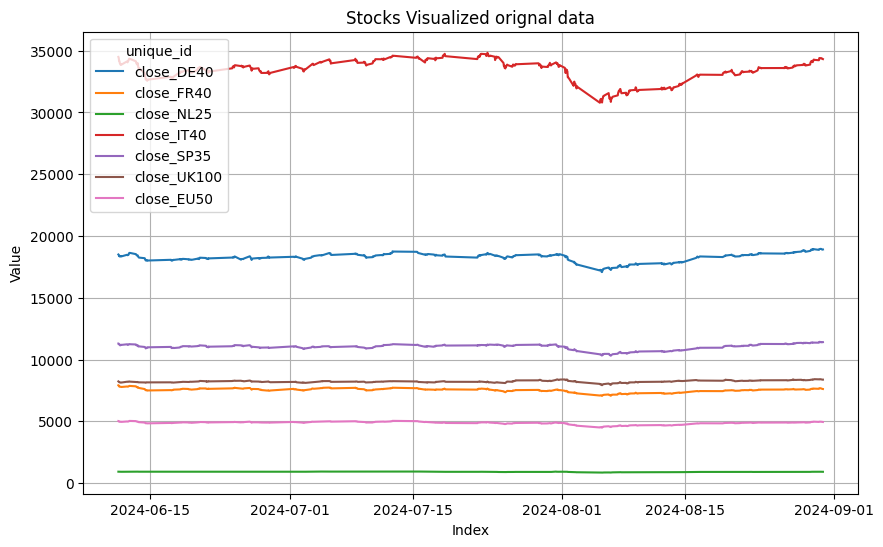

In [57]:
# Plotting indices prices
plt.figure(figsize=(10, 6))
sns.lineplot(data=levels, x='ds', y='y', hue='unique_id')
plt.title('Stocks Visualized orignal data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Calculation of Log Return data

In [58]:
# Ensure 'datetime' is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort the data by datetime just to ensure correct order
df.sort_values(by='datetime', inplace=True)

# Create a new DataFrame to store the log returns
log_returns_df = df.copy()

# Calculate the log returns for each 'close_' column
for col in df.columns:
    if 'close_' in col:  # Only calculate log returns for columns that contain 'close_'
        log_returns_df[col] = np.log(df[col] / df[col].shift(1))

# Display the log returns DataFrame
print(log_returns_df)
log_returns_df.dropna(inplace=True)

               datetime  close_DE40  close_FR40  close_NL25  close_IT40  \
0   2024-06-11 09:00:00         NaN         NaN         NaN         NaN   
1   2024-06-11 10:00:00   -0.001487   -0.001454   -0.001491   -0.002497   
2   2024-06-11 11:00:00   -0.005836   -0.010236   -0.004279   -0.007234   
3   2024-06-11 12:00:00    0.001306    0.000038    0.001031   -0.000205   
4   2024-06-11 13:00:00   -0.002777   -0.003431   -0.001487   -0.005079   
..                  ...         ...         ...         ...         ...   
595 2024-08-30 15:00:00   -0.000079   -0.000535   -0.000706    0.000058   
596 2024-08-30 16:00:00   -0.001690   -0.002302   -0.002480   -0.000931   
597 2024-08-30 17:00:00   -0.000952   -0.001559    0.001002   -0.000146   
598 2024-08-30 18:00:00   -0.000026   -0.000525   -0.001328   -0.000815   
599 2024-08-30 19:00:00    0.000476   -0.000604   -0.000512   -0.000291   

     close_SP35  close_UK100  close_EU50  
0           NaN          NaN         NaN  
1     -0.0005

In [63]:
# Melt the Data_log_returns for Statsforecast
log_returns_levels = log_returns_df.melt(id_vars='datetime', var_name='unique_id', value_name='y')        # Stocks are the variables and go under unique_id and the value_name is 'y'
log_returns_levels.rename(columns={'datetime': 'ds'}, inplace=True)
log_returns_levels.count()

ds           4193
unique_id    4193
y            4193
dtype: int64

Grappfical representation of Log return data

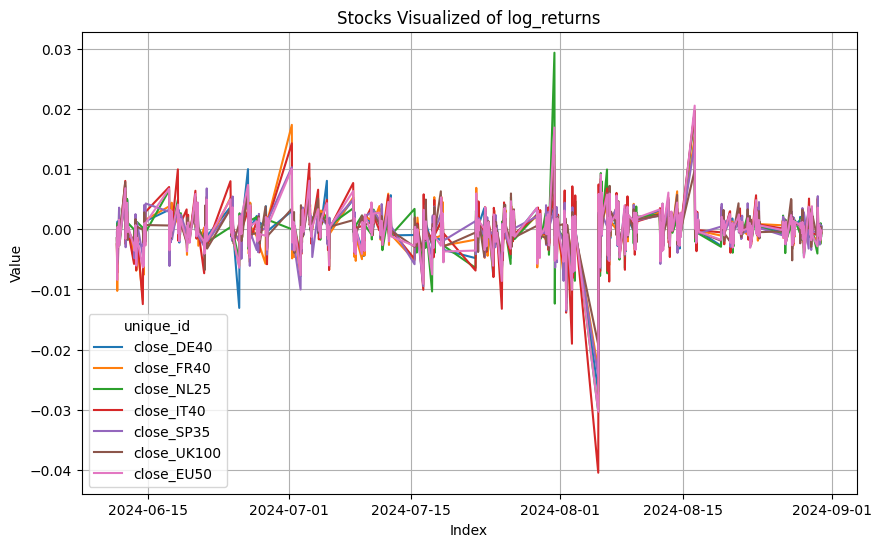

In [64]:
# Plotting Levels 1 to 10
plt.figure(figsize=(10, 6))
sns.lineplot(data=log_returns_levels, x='ds', y='y', hue='unique_id')
plt.title('Stocks Visualized of log_returns')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [62]:
#returns_df.to_csv('return.csv')
#log_returns_df.to_csv('log_return.csv')